# **Imports**

In [ ]:
!pip install open3d ipympl

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from math import cos, sin, pi
import open3d as o3d

In [11]:
# Support for third party widgets will remain active for the duration of the session.
from google.colab import output
output.enable_custom_widget_manager()

In [14]:
# Enable interactive plots in Jupyter
%matplotlib widget

# **ICP : correspondance & transforomations funcs**

the **mean_dist** function calculates the mean distance (also known as the residual) between corresponding points in two point clouds.

***np.linalg.norm(points1 - points2, axis=1)*** :
computes the Euclidean distance between corresponding points in the two point clouds.
***np.mean(distances)*** :
then calculates the average of these distances and returns the result.

In [ ]:
def mean_dist(points1, points2):
    """Calculate mean distance (residual) between corresponding points in two point clouds."""
    distances = np.linalg.norm(points1 - points2, axis=1)
    return np.mean(distances)


The ***icp_core*** function computes the transformation matrix that aligns one point cloud (points1) with another (points2) using the ***Singular Value Decomposition (SVD***) method. This is the core step of the ***ICP*** algorithm, used for point cloud registration.

In [ ]:
def icp_core(points1, points2):
    """Compute the transformation from points1 to points2 using SVD."""
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)

    p1i = (points1 - centroid1).T
    p2i = (points2 - centroid2).T

    H = p1i @ p2i.T
    U, _, VT = la.svd(H)

    R = VT.T @ U.T
    if np.linalg.det(R) < 0:
        VT[2, :] *= -1
        R = VT.T @ U.T

    t = centroid2 - R @ centroid1

    T = np.eye(4)
    T[0:3, 0:3] = R
    T[0:3, 3] = t
    return T

# ***ICP Visualization***

In [12]:
def icp_with_individual_plots(points_source, points_target, n_iter=20, threshold=0.01):
    """Run ICP with a new plot for each iteration showing the current transformation state."""
    points_1 = points_source.copy()
    T_accumulated = np.eye(4)
    residuals = []

    for i in range(n_iter):
        N = points_1.shape[0]
        points_2_nearest = np.zeros_like(points_1)

        # Find nearest neighbors in target for each point in source
        for j in range(N):
            distances = np.linalg.norm(points_1[j] - points_target, axis=1)
            nearest_index = np.argmin(distances)
            points_2_nearest[j] = points_target[nearest_index]

        # Compute transformation for this iteration
        T = icp_core(points_1, points_2_nearest)
        T_accumulated = np.dot(T, T_accumulated)

        # Apply transformation to source points
        points_1_homogeneous = np.hstack((points_1, np.ones((N, 1))))
        points_1 = (np.dot(T, points_1_homogeneous.T)).T[:, :3]

        # Calculate mean residual distance
        mean_distance = mean_dist(points_1, points_target)
        residuals.append(mean_distance)

        # Plot the current iteration state
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Plot target points in green
        ax.scatter(points_target[:, 0], points_target[:, 1], points_target[:, 2], color='green', s=1, label='Target')

        # Plot transformed source points in red
        ax.scatter(points_1[:, 0], points_1[:, 1], points_1[:, 2], color='red', s=1, label=f'Source (Iteration {i+1})')

        # Set title and labels
        ax.set_title(f"ICP Transformation - Iteration {i+1}\nResidual Error: {mean_distance:.4f}")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()

        # Display the plot for this iteration
        plt.show()

        # Stop if converged
        if mean_distance < threshold:
            print("Converged!")
            break

    return T_accumulated, residuals

**function applies a transformation (rotation and translation) to a set of 3D points, creating a "perturbed" or transformed version of the original point cloud.**

In [15]:
def perturb_data(points, R_true, t_true):
    """Apply rotation and translation to create a perturbed version of the original point cloud."""
    perturbed_points = (R_true @ points.T).T + t_true.T
    return perturbed_points

**Parameters for the transformation to be passed in perturb_data func**

In [8]:
angle = pi / 2
R_true = np.array([[cos(angle), -sin(angle), 0],
                   [sin(angle), cos(angle), 0],
                   [0, 0, 1]])  # 3D rotation in xy-plane
t_true = np.array([[-7], [5], [0]])  # 3D translation

**Load the target point cloud from the .obj file**

In [9]:
pcd_target = o3d.io.read_triangle_mesh('/content/cat1_un4.obj')
pcd_target.compute_vertex_normals()
points_target = np.asarray(pcd_target.vertices)

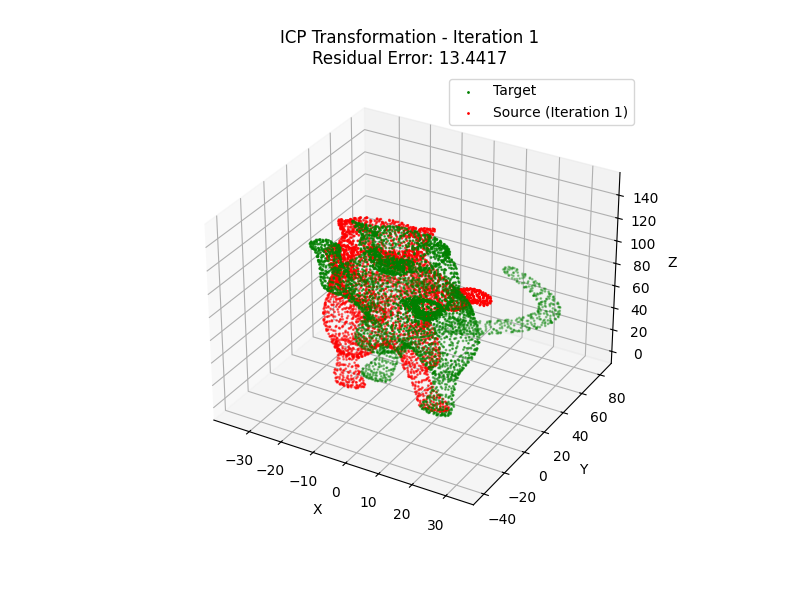

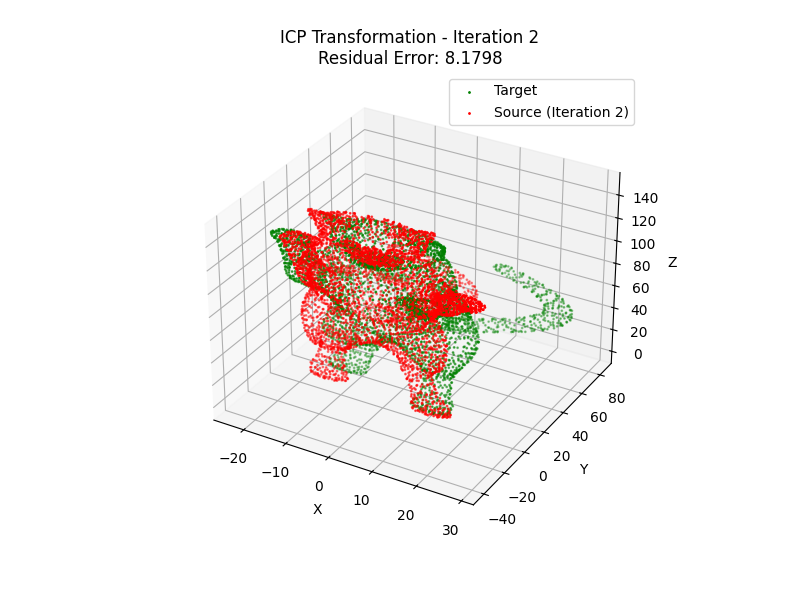

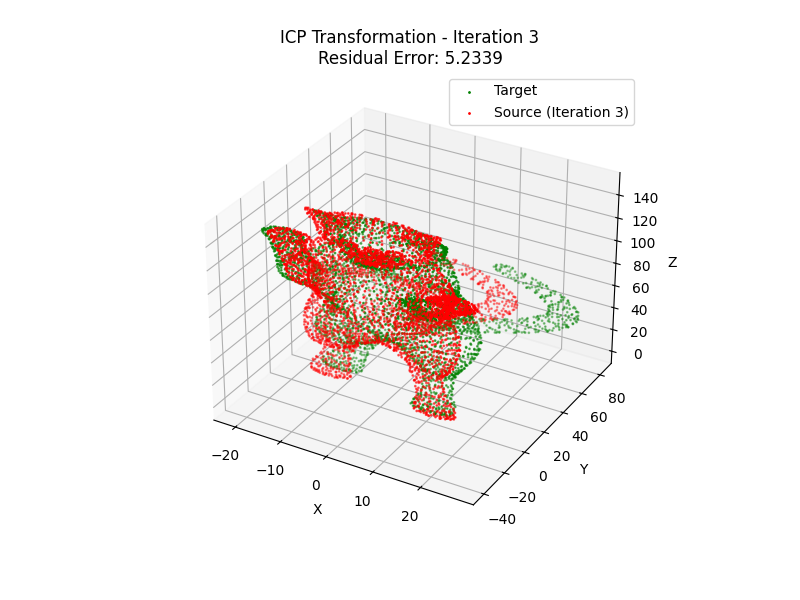

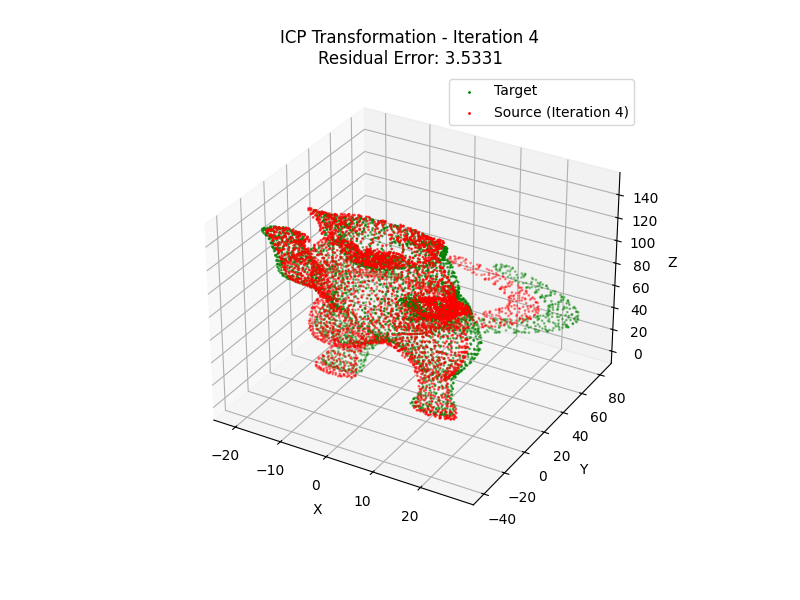

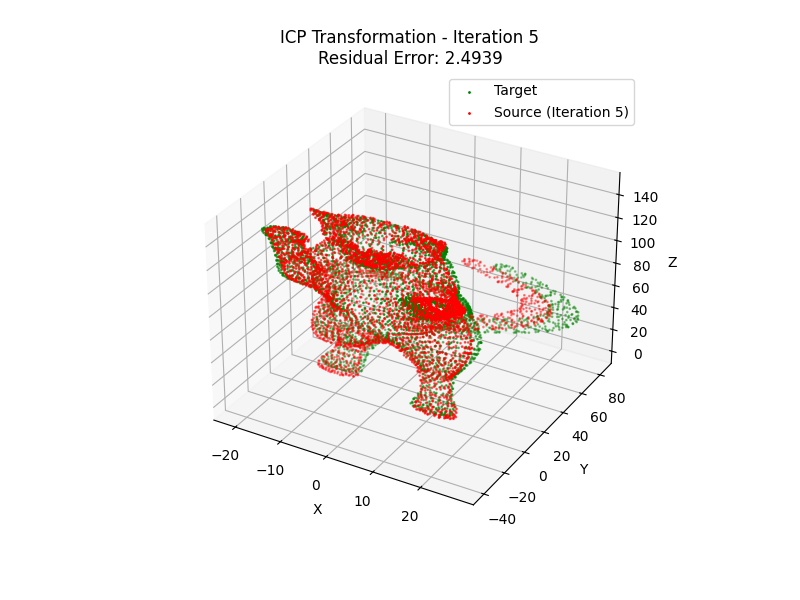

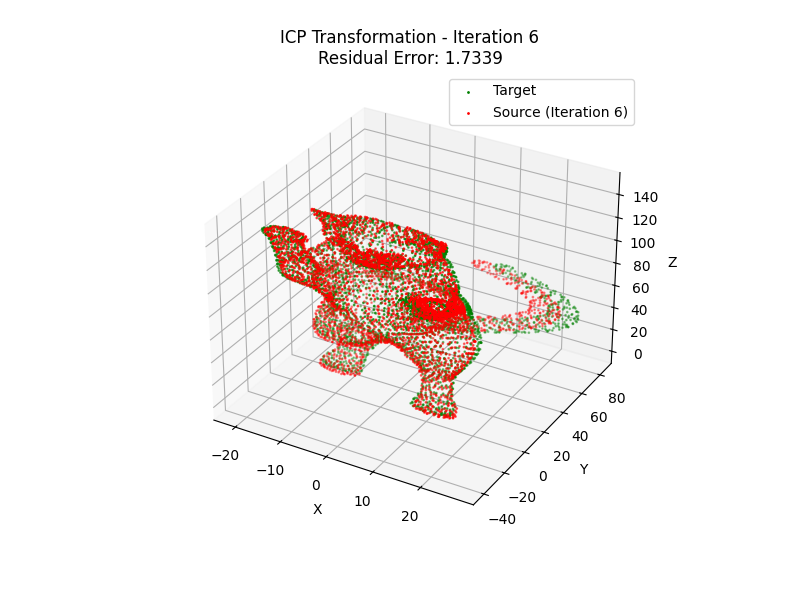

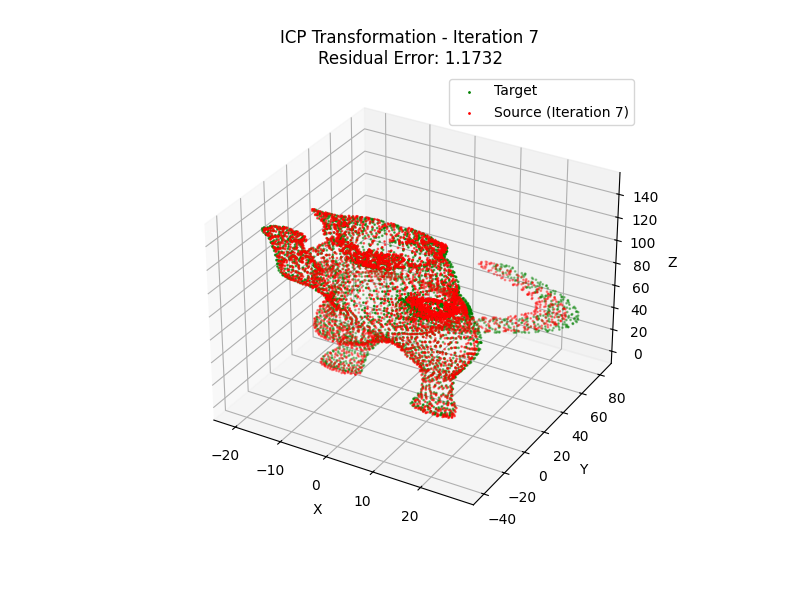

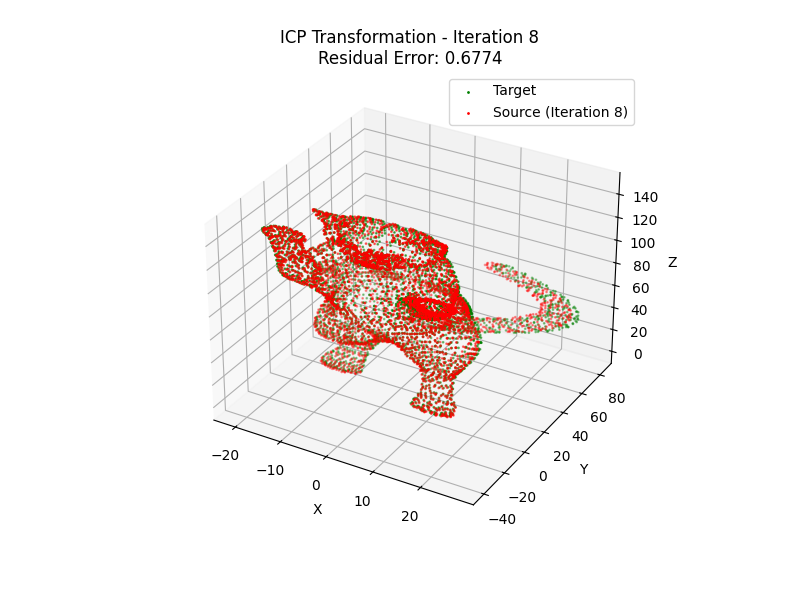

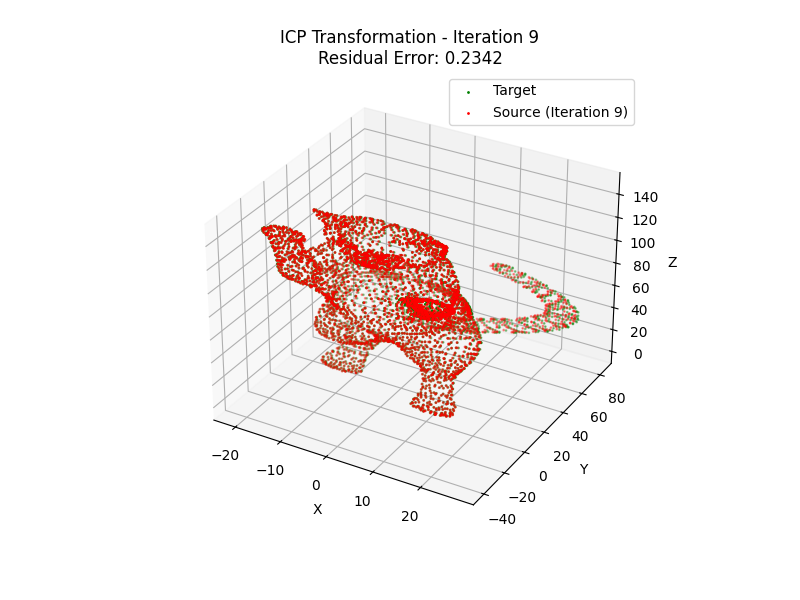

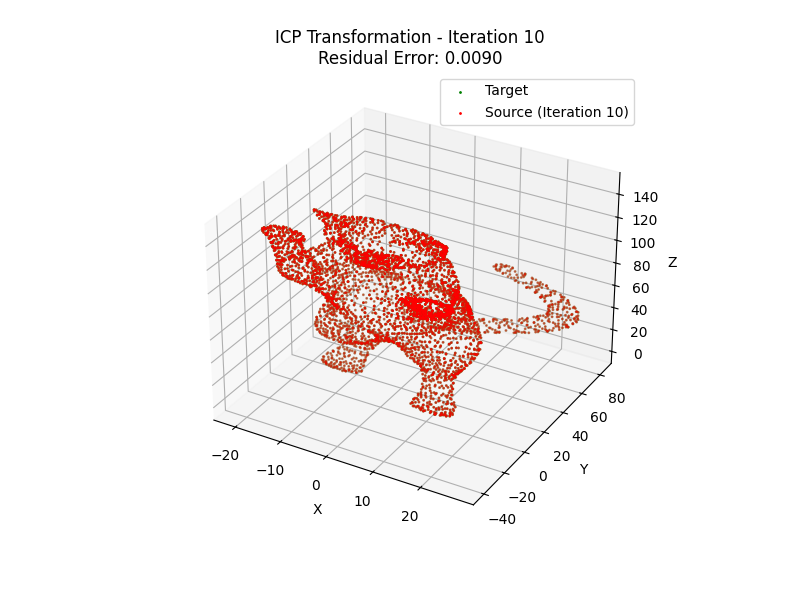

Converged!


In [10]:
# Create perturbed source point cloud
points_source_perturbated = perturb_data(points_target, R_true, t_true)

# Run ICP with individual plots for each iteration
final_transformation, residuals = icp_with_individual_plots(points_source_perturbated, points_target)

**# Print final results**

In [ ]:
print("Final Transformation Matrix:")
print(final_transformation)
print("Residuals per iteration:", residuals)